# Augment example

In [1]:
# pip install git+https://github.com/Labbeti/MLU

In [2]:
from mlu.transforms import StretchPadCrop, CutOutSpec, Occlusion, RandomChoice, Compose
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

/home/labbeti/anaconda3/envs/env_sslh/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
# Optional transform to spectrogram
n_mels = 64
n_time = 500
sr = 32000
n_fft = 2048
hop_length = sr * 10 // n_time

transform_to_spec = Compose(
    MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),
    AmplitudeToDB(),
)

StretchPadCrop only resample signal waveform of length L to length (L * rate) and pad/crop it to return a waveform of length L.
The rate is uniformly sampled from a pre-defined range "rates".

CutOutSpec remove some value in a spectrogram by replacing value in a random rectangle area by -80.0 dB.
The width and height of the rectangle will be defined by scales (height_spec * height_scale, width_spec * width_scale),
where spectrogram has shape (height_spec, width_spec) and scales are uniformly generated in pre-defined ranges "width_scales" and "height_scales".

Occlusion replace a interval of values in the waveform by 0.
The length of this interval is defined by the scale uniformly sampled from the range "scales".

## Compose for weak augment

In [4]:
p = 0.5
augm = RandomChoice(
    Compose(
        StretchPadCrop(rates=(0.9, 1.1), p=p),
        transform_to_spec,
    ),
    Compose(
        transform_to_spec,
        CutOutSpec(width_scales=(0.1, 0.5), height_scales=(0.1, 0.5), fill_value=-80.0, p=p),
    ),
    Compose(
        Occlusion(scales=(0.1, 0.3), fill_value=0.0, p=p),
        transform_to_spec,
    ),
)

In [5]:
print(augm)

RandomChoice(
  (0): Compose(
    (0): StretchPadCrop()
    (1): Compose(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
  )
  (1): Compose(
    (0): Compose(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
    (1): CutOutSpec()
  )
  (2): Compose(
    (0): Occlusion()
    (1): Compose(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
  )
)


# Test

In [6]:
import math
import torch

from matplotlib import pyplot as plt
from torch import Tensor

In [7]:
def gen_note(freq_note: float, duration: float, sample_rate: int, amplitude: float = 1.0) -> Tensor:
    nb_samples = duration * sample_rate
    x = torch.arange(start=0, end=nb_samples)
    return torch.sin(freq_note * x * 2.0 * math.pi / sample_rate) * amplitude

# 0.5 Hz, 10 s
waveform = gen_note(0.5, 10, sr)
spec = transform_to_spec(waveform)
stretch = StretchPadCrop(rates=(0.5, 0.5), p=p)
cutout_spec = CutOutSpec(width_scales=(0.4, 0.4), height_scales=(0.4, 0.4), p=p)
occlusion = Occlusion(scales=(0.4, 0.5))

/home/labbeti/anaconda3/envs/env_sslh/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/labbeti/anaconda3/envs/env_sslh/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


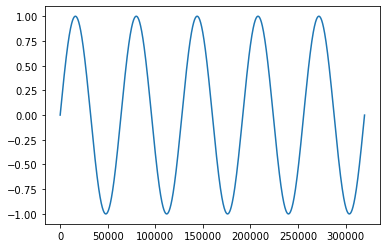

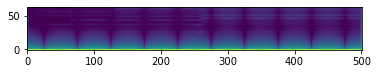

In [8]:
plt.plot(waveform)
plt.show()

plt.imshow(spec, origin="lower")
plt.show()

StretchPadCrop example:

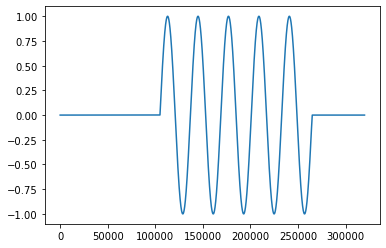

In [9]:
plt.plot(stretch(waveform))
plt.show()

CutOutSpec example:

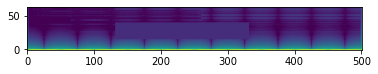

In [10]:
plt.imshow(cutout_spec(spec), origin="lower")
plt.show()

Occlusion example:

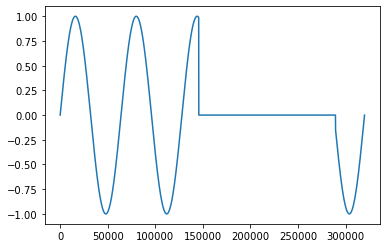

In [11]:
plt.plot(occlusion(waveform))
plt.show()

Augments composed example:

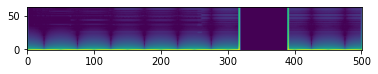

In [12]:
plt.imshow(augm(waveform), origin="lower")
plt.show()